In [1]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from scipy.special import xlogy
from sklearn import preprocessing
from scipy.stats import mode
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns


# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

def timer(method):
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        te = perf_counter()
        tlapsed = te-ts
        print(f"{tlapsed//60} mins and {tlapsed%60:0.2f} secs")
        return result
    return timed

In [2]:
s = [[1,1,1],
     [1,1,1],
     [1,1,1]]


@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc


@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def gscott(n, F, k, T, Du=0.16, Dv=0.08, dt=1.0, dx=1.0):
    np.random.seed(seed=5000000)
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    U[m-r:m+r, m-r:m+r] = 0.5
    U += np.random.normal(scale=0.05, size=U.shape)
    V += np.random.normal(scale=0.05, size=V.shape)
    return gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

def calc_objects(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels2 = ndimage.label(binarized2, structure=s)
    if labels1[1] > labels2[1]:
        bins, edges = np.histogram(labels1[0], bins=labels1[1])
        return bins[1:]

    # Try inversed region
    if labels2[1] > 1:
        bins, edges = np.histogram(labels2[0], bins=labels2[1])
        return bins[1:]
    
    # No objects
    return np.zeros(1)

def bulkrun(f, k, n=250, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    u_median, v_median = np.zeros_like(f), np.zeros_like(f)
    u_std, v_std = np.zeros_like(f), np.zeros_like(f)
    for index, F in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, F, k[index], T)
        obj_u = calc_objects(u)
        obj_v = calc_objects(v)
        
        u_median[index] = np.median(obj_u)
        u_std[index] = np.std(obj_u)
        v_median[index] = np.median(obj_v)
        v_std[index] = np.std(obj_v)
    return (u_median, v_median), (u_std, v_std)

def shannon_entropy(inp):
    if len(np.unique(inp)) == 1:
        return 0.0
    p = gaussian_kde(inp)
    return quad(lambda x: -p.pdf(x)*p.logpdf(x), -10000, 100000, limit=10000)[0]

def bulk_entropy(f, k, n=200, T=10000):
    iters = len(f) * len(k)
    
    f, k = np.meshgrid(f, k)
    outp = np.zeros_like(f)
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        obj_u = calc_objects(u)
        outp[index] = shannon_entropy(obj_u)
    return outp

def bulk_entropy1d(f, k, n=250, T=10000):
    iters = len(f)
    
    outp = np.zeros_like(f)
    for index, _f in tqdm(np.ndenumerate(f), total=iters):
        u, v = gscott(n, _f, k[index], T)
        obj_u = calc_objects(u)
        outp[index] = shannon_entropy(obj_u)
    return outp

def gaus_hack(inp):
    if len(np.unique(inp)) == 1:
        return lambda x: 0
    return gaussian_kde(inp)

def fim(x, ind, pdfs, df, dk):
    if np.all(ind): # (1, 1) index
        vals = np.array([pdfs[0](x), pdfs[1](x), pdfs[2](x)])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * dk * dk)
    elif np.any(ind): # (1, 0) or (0, 1) index
        vals = np.array([i(x) for i in pdfs])
        if np.any(vals < 1e-8):
            return 0.0
        return vals[0] * (np.log(vals[1]) - np.log(vals[2]))\
               * (np.log(vals[3]) - np.log(vals[4])) / (4.0 * df * dk)
    # (0, 0) index otherwise
    vals = np.array([pdfs[0](x), pdfs[3](x), pdfs[4](x)])
    if np.any(vals < 1e-8):
        return 0.0
    return vals[0] * (np.log(vals[1]) - np.log(vals[2]))**2 / (4.0 * df * df)
    
def fisher_matrix(inps, df, dk):
    p = [gaus_hack(i) for i in inps]
    FIM = np.zeros((2, 2))
    for i in np.ndindex(2, 2):
        FIM[i] = quad(fim, -10000, 100000, args=(i, p, df, dk), limit=10000)[0]
    return FIM


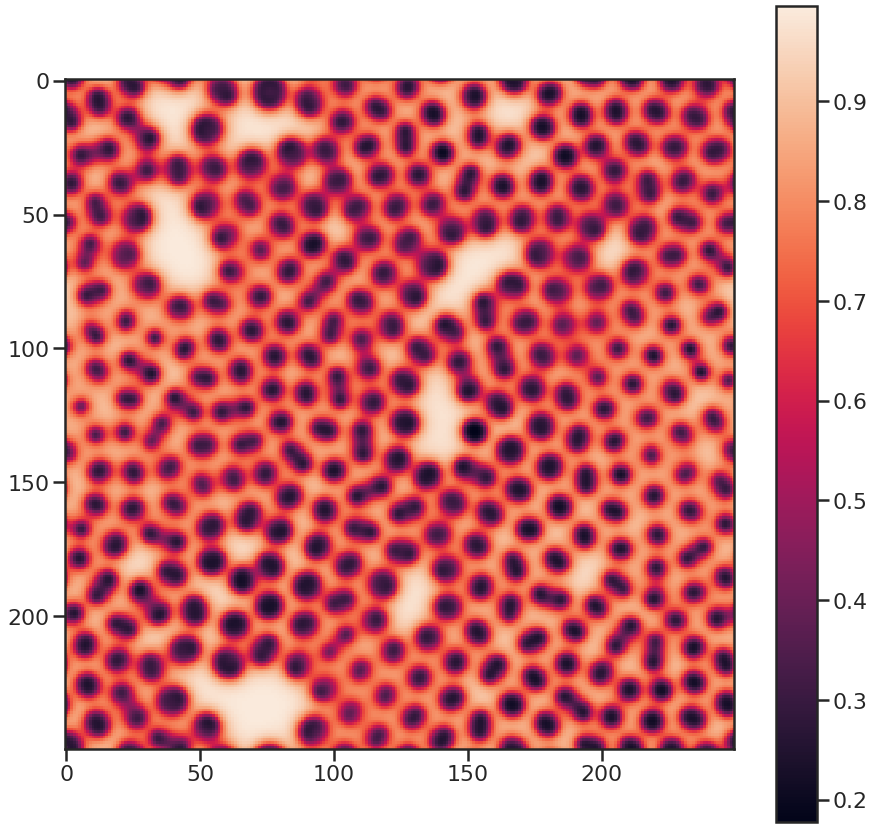

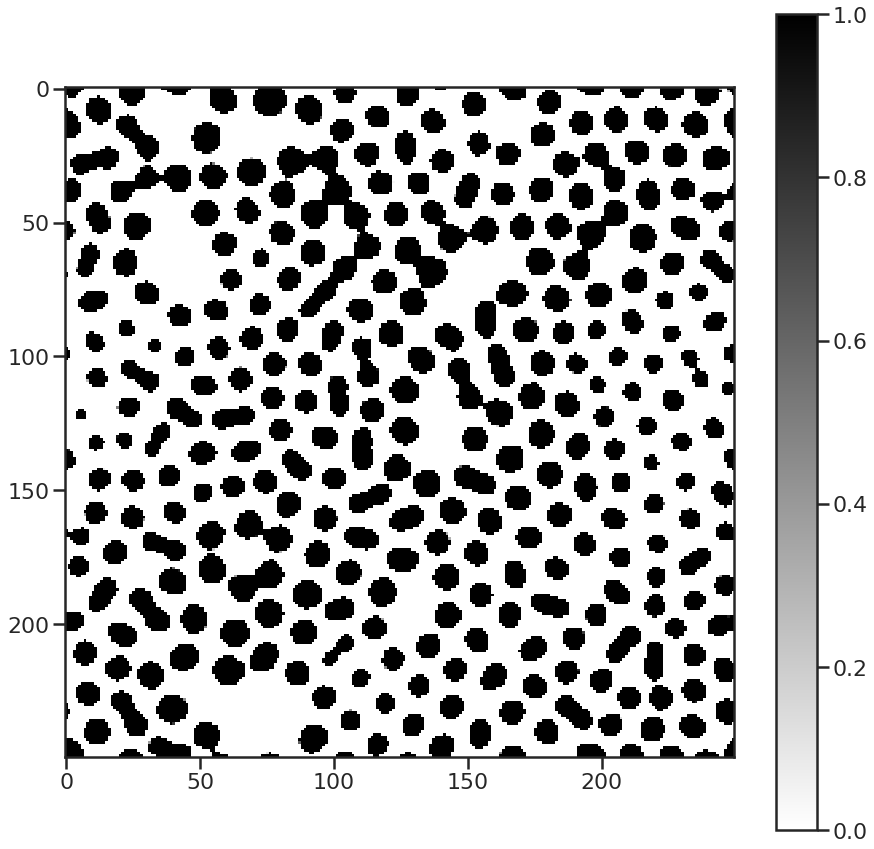

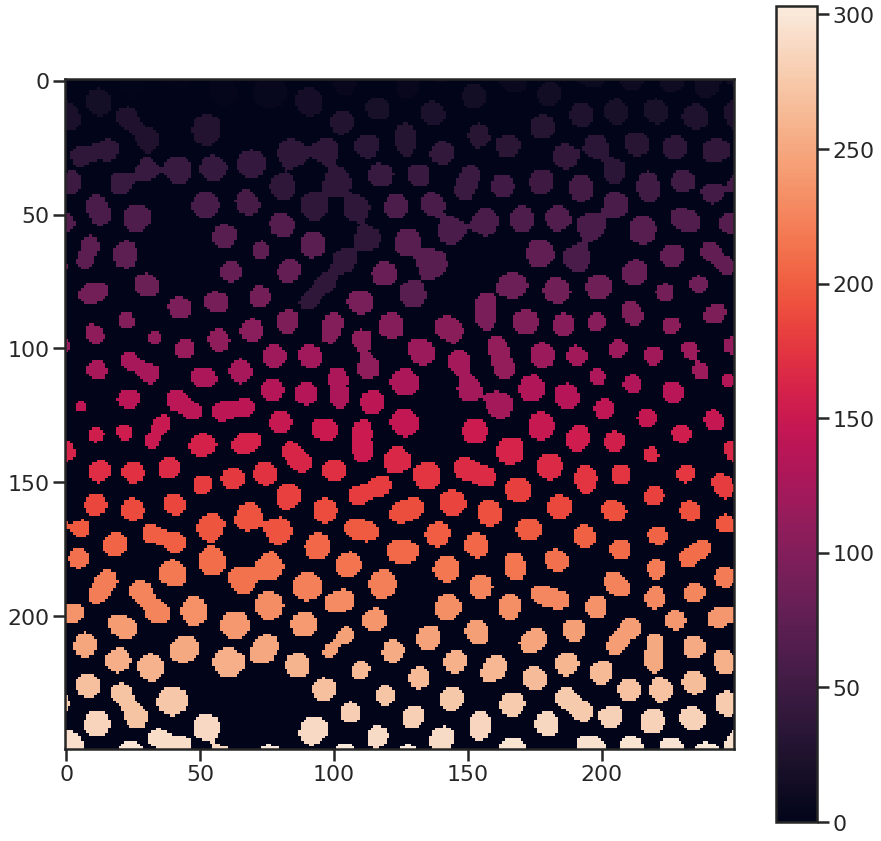

In [4]:
f_min = 0.0238191
f_max = 0.0271360
k_min = 0.05869347
k_max = 0.06141

u, v = gscott(250, f_min, k_min, 20000)
plt.figure(figsize=(15,15))
plt.imshow(u)
plt.colorbar()
plt.show()

def show_objects(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    labels2 = ndimage.label(binarized2, structure=s)

    if labels1[1] > labels2[1]:
        return labels1[0]
    return labels2[0]

def show_binary(inp):
    fftding = np.fft.fft2(inp)
    outp = ndimage.fourier_ellipsoid(fftding, 1.1)*100
    outp = np.fft.ifft2(ndimage.fourier_gaussian(outp, 1.01)).real*10

    binarized1 = np.clip(outp-((outp.min() + outp.max())/2), 0, 1)
    labels1 = ndimage.label(binarized1, structure=s)
    binarized2 = np.clip((outp-((outp.min() + outp.max())/2))*-1, 0, 1)
    return binarized2

plt.figure(figsize=(15,15))
plt.imshow(show_binary(u), cmap='binary')
plt.colorbar()
plt.show()



plt.figure(figsize=(15,15))
plt.imshow(show_objects(u))
plt.colorbar()
plt.show()


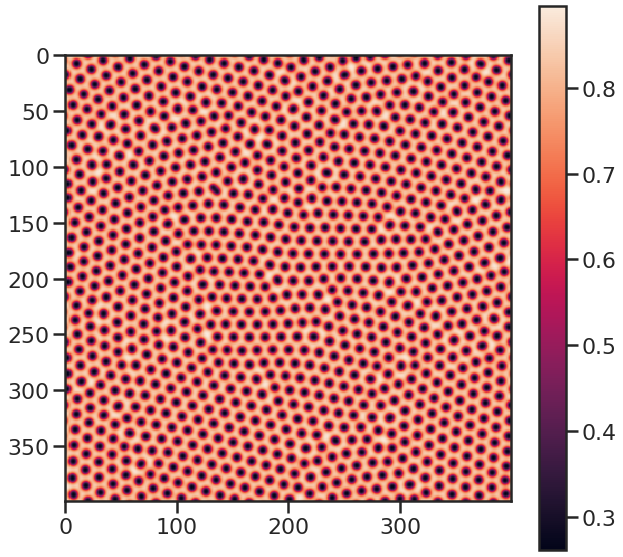

In [54]:
u, v = gscott(400, f_max, k_max, 50000)
plt.figure(figsize=(10,10))
plt.imshow(u)
plt.colorbar()
plt.show()